In [33]:
import scanpy as sc
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from scimilarity.utils import lognorm_counts, align_dataset, get_centroid
from scimilarity import CellEmbedding, CellQuery, Interpreter
import os
random_seed = 42
np.random.seed(random_seed)

import pandas as pd

sc.set_figure_params(dpi=100)

In [6]:
# Instantiate the CellQuery object
# Set model_path to the location of the uncompressed model
model_path = "/workspace/models/model_v1.1"
cq = CellQuery(model_path, use_gpu=True)

In [7]:
data_path = "/workspace/NB_bone_Met_preprocessed.h5ad"
data = sc.read(data_path)
print(f"Data cell 1: {data.obs['cell1']}")
print(f"Data cell 1: {data.obs['cell2'].cat.categories}")

subset = data[data.obs['cell1'].isin(["B cells", "T cells", "myeloid", "immature B", "Neutrophil", "progenitor"])]
print(f"Subset: {subset}")

Data cell 1: cell_ID
NBBM1_AAACGAAGTCCGGCAT-1           T cells
NBBM1_AAACGCTGTCACAATC-1           T cells
NBBM1_AAAGGATGTAGGCTGA-1           B cells
NBBM1_AAAGGTAGTCTCAGGC-1           B cells
NBBM1_AAAGGTAGTGAGTGAC-1           T cells
                                   ...    
NB34_Bone_TTTGTTGAGCGAAACC-1       T cells
NB34_Bone_TTTGTTGAGTCGCTAT-1    Neutrophil
NB34_Bone_TTTGTTGAGTCGGCAA-1       T cells
NB34_Bone_TTTGTTGGTAAGGCTG-1       T cells
NB34_Bone_TTTGTTGGTGCGTGCT-1       B cells
Name: cell1, Length: 36763, dtype: category
Categories (13, object): ['B cells', 'NK', 'Neutrophil', 'T cells', ..., 'plasma', 'pro B', 'proerythroblast', 'progenitor']
Subset: View of AnnData object with n_obs × n_vars = 29935 × 25139
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'RNA

In [8]:
subset.X = subset.layers['RNA']
subset.layers['counts']=subset.layers['RNA']

subset = align_dataset(subset, cq.gene_order)
subset = lognorm_counts(subset)

In [18]:
fm_basic_signature = ["SPP1", "TREM2", "GPNMB", "MMP9", "CHIT1", "CHI3L1"]
sc.tl.score_genes(subset, fm_basic_signature)

In [16]:
print(subset.obs)

                                   cell1          cell2        fraction  \
NBBM1_AAACGAAGTCCGGCAT-1         T cells          CTL-1  non-metastatic   
NBBM1_AAACGCTGTCACAATC-1         T cells          CTL-1  non-metastatic   
NBBM1_AAAGGATGTAGGCTGA-1         B cells        Naive B  non-metastatic   
NBBM1_AAAGGTAGTCTCAGGC-1         B cells       Memory B  non-metastatic   
NBBM1_AAAGGTAGTGAGTGAC-1         T cells       T helper  non-metastatic   
...                                  ...            ...             ...   
NB34_Bone_TTTGTTGAGCGAAACC-1     T cells          CTL-1      metastatic   
NB34_Bone_TTTGTTGAGTCGCTAT-1  Neutrophil  neutrophils-2      metastatic   
NB34_Bone_TTTGTTGAGTCGGCAA-1     T cells          CTL-1      metastatic   
NB34_Bone_TTTGTTGGTAAGGCTG-1     T cells          CTL-1      metastatic   
NB34_Bone_TTTGTTGGTGCGTGCT-1     B cells       Memory B      metastatic   

                                 sample                       cell_ID  \
NBBM1_AAACGAAGTCCGGCAT-1  

In [28]:
sig_query_threshold = subset.obs.score.quantile(0.999)
cells_used_in_query = subset.obs.score >= sig_query_threshold
print(f"Cells used in query {cells_used_in_query}")
subset.obs["used_in_query"] = cells_used_in_query

Cells used in query NBBM1_AAACGAAGTCCGGCAT-1        False
NBBM1_AAACGCTGTCACAATC-1        False
NBBM1_AAAGGATGTAGGCTGA-1        False
NBBM1_AAAGGTAGTCTCAGGC-1        False
NBBM1_AAAGGTAGTGAGTGAC-1        False
                                ...  
NB34_Bone_TTTGTTGAGCGAAACC-1    False
NB34_Bone_TTTGTTGAGTCGCTAT-1    False
NB34_Bone_TTTGTTGAGTCGGCAA-1    False
NB34_Bone_TTTGTTGGTAAGGCTG-1    False
NB34_Bone_TTTGTTGGTGCGTGCT-1    False
Name: score, Length: 29935, dtype: bool


In [29]:
#avg_cell = get_centroid(subset.layers['counts'][subset.obs["used_in_query"]])
mask_array = subset.obs["used_in_query"].values
avg_cell = get_centroid(subset.layers['counts'][mask_array])
avg_embedding = cq.get_embeddings(avg_cell)

In [31]:
pos = subset[subset.obs.score >= sig_query_threshold]
neg = sc.pp.subsample(
    subset[subset.obs.score < sig_query_threshold],
    n_obs=len(pos),
    random_state=0,
    copy=True,
)

In [34]:
explainer = Interpreter(cq.model, cq.gene_order)
attrs = explainer.get_attributions(pos.X, neg.X)
attrs_df = explainer.get_ranked_genes(attrs)

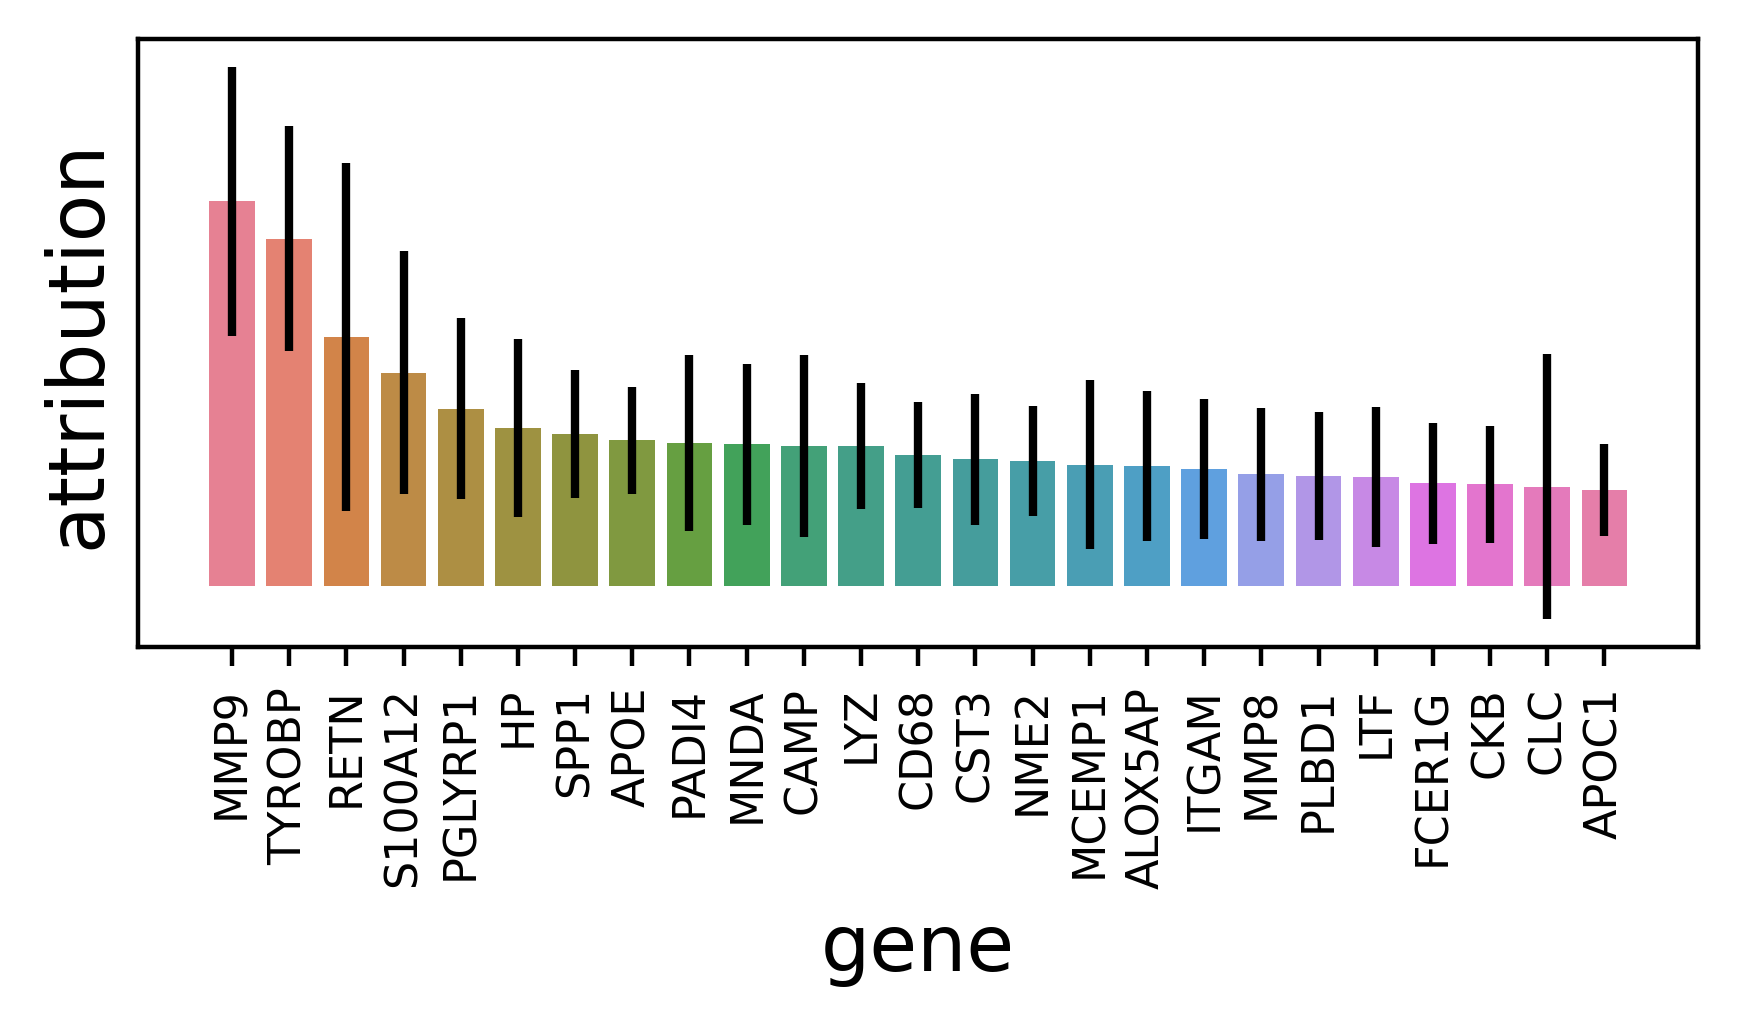

In [35]:
explainer.plot_ranked_genes(attrs_df, n_plot=25)

In [36]:
meta = cq.cell_metadata

In [37]:
# Show a random sampling of 5 annotations
meta.sample(5)

,index,study,sample,prediction,fm_signature_score,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,prediction_nn_dist,...,cell_line,iPSC-derived,ESC-derived,xenograft,tissue,cell_line_cleaned,disease,FACS_sort,sex_cleaned,author_label
10834602,10834602,GSE162115,GSM4933433,mature NK T cell,0.000000,517.0,989.0,68.0,6.875632,2.854681e-02,...,False,False,False,False,stomach,NA,Gastrointestinal stromal tumor,NA,NA,NA
16083685,16083685,83ed3be8-4cb9-43e6-9aaa-3fbbf5d1bd3a,286e7e5f-4c9a-4caf-b02c-2cd3cb74f113,common lymphoid progenitor,0.000000,2886.0,10627.0,310.0,2.917098,1.200896e-02,...,False,NA,NA,NA,thymus,NA,healthy,NA,NA,thymocyte
20597320,20597320,436154da-bcf1-4130-9c8b-120ff9a888f2,b0c3cf74-58cf-43e7-b4df-61ef0b3a9fdc,"CD4-positive, alpha-beta T cell",0.000000,1134.0,4199.0,247.0,5.882353,-2.384186e-07,...,False,NA,NA,NA,blood,NA,healthy,NA,NA,"CD4-positive, alpha-beta T cell"
4223988,4223988,GSE161918,GSM4929212,"CD4-positive, alpha-beta T cell",-0.005767,1730.0,5073.0,119.0,2.345752,7.717609e-03,...,False,False,False,False,blood,NA,COVID-19;healthy,NA,NA,NA
19931729,19931729,4b54248f-2165-477c-a027-dd55082e8818,BPH340PrSF_Via,secretory cell,-0.076219,2075.0,10135.0,278.0,2.742970,3.576565e-02,...,False,NA,NA,NA,transition zone of prostate,NA,prostatic hypertrophy,NA,NA,basal cell of prostate epithelium


In [39]:
# 1. Extract DE signature for a known cell type
sc.tl.rank_genes_groups(subset, groupby="cell1", method="wilcoxon") ## do it as well with cell2, repeating the scimilarity search for finer grained groups

In [42]:
# 2. Get top 50 marker genes for the cell type of interest
celltype = "NK"
for cell in ["B cells", "T cells", "myeloid", "immature B", "Neutrophil", "progenitor"]:
    ranked_genes = subset.uns['rank_genes_groups']['names'][cell][:50]
    print(f" Cell: {cell} ranked: {ranked_genes}")

 Cell: B cells ranked: ['IGHM' 'HLA-DRA' 'CD79B' 'CD74' 'CD37' 'TCL1A' 'CD79A' 'VPREB3'
 'HLA-DPB1' 'AFF3' 'BTG1' 'PCDH9' 'IGKC' 'YBX3' 'HLA-DPA1' 'RPS11' 'MZB1'
 'HLA-DQB1' 'IGHD' 'PTMA' 'CD72' 'CD24' 'HLA-DMA' 'IGLC2' 'HLA-DRB1'
 'MS4A1' 'TCF4' 'RALGPS2' 'RCSD1' 'JUND' 'BACH2' 'CXCR4' 'SNHG7' 'SPIB'
 'BCL7A' 'STX7' 'LIMD2' 'NCF1' 'PAX5' 'MTRNR2L12' 'RPL13A' 'CCDC191'
 'RPL15' 'RPS27' 'HIST1H1C' 'TMEM243' 'H3F3A' 'RACK1' 'CD22' 'FCRLA']
 Cell: T cells ranked: ['CD3D' 'IL32' 'B2M' 'CD3G' 'CD3E' 'TRAC' 'TRBC2' 'CD2' 'HCST' 'GZMM'
 'ARL4C' 'GIMAP7' 'CCL5' 'RPS3' 'GZMA' 'MYL12A' 'LCK' 'GIMAP4' 'CTSW'
 'HLA-E' 'CD7' 'NKG7' 'CD8A' 'CST7' 'CALM1' 'RPS15A' 'SLFN5' 'TMSB4X'
 'PTPRC' 'SYNE2' 'GZMH' 'LINC00861' 'KLRD1' 'CD247' 'EVL' 'PRF1' 'RPL30'
 'SKAP1' 'RPL41' 'SARAF' 'GNLY' 'RPL36AL' 'TRAF3IP3' 'RPS4X' 'CD99' 'HOPX'
 'LAT' 'HLA-B' 'RPL14' 'KLRG1']
 Cell: myeloid ranked: ['LYZ' 'CST3' 'FTL' 'TYROBP' 'S100A9' 'MNDA' 'FCN1' 'AIF1' 'LST1' 'FCER1G'
 'VCAN' 'CTSS' 'S100A8' 'S100A6' 'PSAP' 'CEBPD'

In [44]:
# 1. Extract DE signature for a known cell type
sc.tl.rank_genes_groups(subset, groupby="cell2", method="wilcoxon") ## do it as well with cell2, repeating the scimilarity search for finer grained groups
       


In [57]:
# 2. Get top 50 marker genes for the cell type of interest
celltype = "NK"
for cell in ['Active B', 'CD4 naive T', 'CD8 naive T', 'CD56bright', 'CD56dim-1',
       'CD56dim-2', 'CTL-1', 'CTL-2', 'Macro', 'Memory B', 'Mono-1', 'Mono-2',
       'NKT', 'Naive B', 'Pro-B', 'T helper', 'Tconv', 'Tumor', 'erythroid',
       'immature NK', 'mDC', 'neutrophils-1', 'neutrophils-2', 'pDC', 'plasma',
       'pre B progenitor', 'pre pro B progenitor', 'pro myeloid',
       'proerythroblast', 'progenitor']:
    try:
        ranked_genes = subset.uns['rank_genes_groups']['names'][cell][:50]
        print(f"Cell: {cell} ranked: {ranked_genes}")
    except KeyError:
        print(f"Cell type '{cell}' not found in ranked genes data")
    except Exception as e:
        print(f"An error occurred with cell type '{cell}': {str(e)}")

Cell: Active B ranked: ['MS4A1' 'CD74' 'IGHD' 'CD37' 'HLA-DRB1' 'HLA-DRA' 'RALGPS2' 'CD79A'
 'IGHM' 'HLA-DPA1' 'HLA-DPB1' 'BANK1' 'LINC00926' 'HLA-DQB1' 'LTB'
 'HLA-DQA1' 'RPL18A' 'MEF2C' 'TCL1A' 'RPS27' 'IGKC' 'HVCN1' 'CD79B'
 'RPS23' 'PLPP5' 'CD22' 'BIRC3' 'RPL8' 'CD52' 'FCRL1' 'RPS8' 'FCER2'
 'RPL13' 'RPL18' 'HLA-DMA' 'RPS11' 'STX7' 'BTG1' 'RPL34' 'RPS5' 'MARCH1'
 'BCL11A' 'SWAP70' 'FCMR' 'IL4R' 'TNFRSF13C' 'RPL11' 'SNX29' 'AFF3' 'FAU']
Cell: CD4 naive T ranked: ['RPL32' 'RPL30' 'RPL34' 'RPS12' 'TPT1' 'RPL13' 'RPL11' 'RPL35A' 'RPS27A'
 'RPS15A' 'IL7R' 'RPL39' 'RPS13' 'RPS25' 'RPS3A' 'RPS8' 'RPL19' 'RPS27'
 'RPS28' 'RPS14' 'RPL14' 'RPL37' 'RPS18' 'LDHB' 'RPL9' 'RPS23' 'RPL36'
 'LTB' 'RPL41' 'RPL18A' 'RPS29' 'RPS21' 'RPL10' 'CCR7' 'RPL18' 'EEF1B2'
 'RPS6' 'RPL21' 'RPL28' 'RPL29' 'EEF1A1' 'RPS4X' 'RPL5' 'RPL22' 'SARAF'
 'RPS3' 'RPL12' 'RPS5' 'TCF7' 'RPL3']
Cell: CD8 naive T ranked: ['RPS12' 'RPL32' 'RPL13' 'RPL34' 'TPT1' 'RPL30' 'RPS3A' 'RPS13' 'RPL19'
 'RPS18' 'RPS27A' 'RPS8' 'RPS14' 